In [5]:
import networkx as nx
import matplotlib.pyplot as plt

In [39]:
G = nx.barabasi_albert_graph(100, 5, seed = 1)
C = nx.clustering(G)

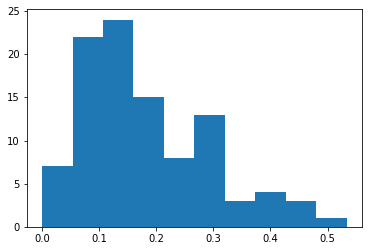

In [43]:
BINs = plt.hist(list(C.values()), bins = 10)

In [48]:
names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
objects = []

for i in range(len(names)):
    with open("../Meta-GNN/meta_gnn/data/ind.{}.{}".format("cora", names[i]), 'rb') as f:
        if sys.version_info > (3, 0):
            objects.append(pkl.load(f, encoding='latin1'))
        else:
            objects.append(pkl.load(f))

In [51]:
objects[0]

<140x1433 sparse matrix of type '<class 'numpy.float32'>'
	with 2647 stored elements in Compressed Sparse Row format>

In [47]:
import numpy as np
import scipy.sparse as sp
import torch
import sys
import pickle as pkl
import networkx as nx
#from normalization import fetch_normalization, row_normalize
from sklearn.metrics import f1_score

In [ ]:
def load_citation(dataset_str="cora", normalization="AugNormAdj", cuda=True):
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset_str.lower(), names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]


    adj, features = preprocess_citation(adj, features, normalization)

    features = torch.FloatTensor(np.array(features.todense())).float()
    labels = torch.LongTensor(labels)
    labels = torch.max(labels, dim=1)[1]
    adj = sparse_mx_to_torch_sparse_tensor(adj).float()

    if cuda:
        features = features.cuda()
        adj = adj.cuda()
        labels = labels.cuda()

    return adj, features, labels

In [53]:
from itertools import combinations
class_label = [0, 1, 2, 3, 4, 5, 6]
combination = list(combinations(class_label, 2))

In [54]:
combination

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 4),
 (3, 5),
 (3, 6),
 (4, 5),
 (4, 6),
 (5, 6)]